# Тематическая классификация длинных текстов - TFIDF и LogReg

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 266, done.
remote: Total 266 (delta 0), reused 0 (delta 0), pack-reused 266
Receiving objects: 100% (266/266), 42.13 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (129/129), done.
     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 1.7MB 6.8MB/s 
     |████████████████████████████████| 307kB 20.3MB/s 
     |████████████████████████████████| 7.1MB 24.5MB/s 
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp36-cp36m-linux_x86_64.whl size=5625274 sha256=55ffbd9b58241873643f2eddf5c5d097303e944a7a8ec6585768e0b48ad8a556
  Stored in directory: /root/.cache/pip/wheels/0c/9d/db/6d3404c33da5b7adb6c6972853efb6a27649d3ba15f7e9bebb
  Created wheel for intervaltree: filename=intervaltree-3.0.2-cp36-none-any.whl size=25791 sha256=ce9e84d251f1331f62e4f5adb57b1e2745816db63e9f5a2ef8453d3c4779f4e2
  Stored in directory: /root/.cache/pip/wheels/08/99/c0/5a5942f5b9567c59c14aac76f95a70bf11dc

In [0]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [3]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Метка', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Метка 7


### Подготовка признаков

In [13]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


In [65]:
MAX_DF = 0.8
MIN_COUNT = 4
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print(list(vocabulary.items())[:10])

Количество уникальных токенов 25848
[('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


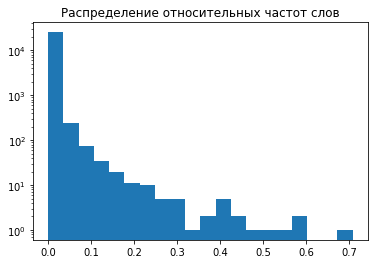

In [66]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

In [67]:
VECTORIZATION_MODE = 'tf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', train_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в обучающей выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))

Размерность матрицы признаков обучающей выборки (11314, 25848)
Размерность матрицы признаков тестовой выборки (11314, 25848)

Количество ненулевых элементов в обучающей выборке 1143672
Процент заполненности матрицы признаков 0.39%

Количество ненулевых элементов в обучающей выборке 730215
Процент заполненности матрицы признаков 0.38%


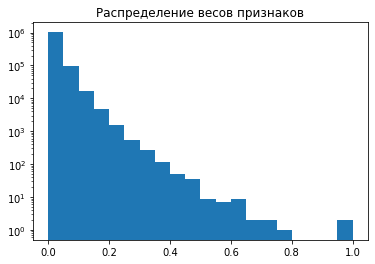

In [68]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [69]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


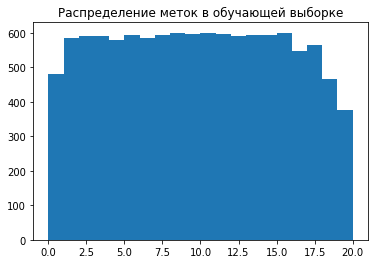

In [70]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

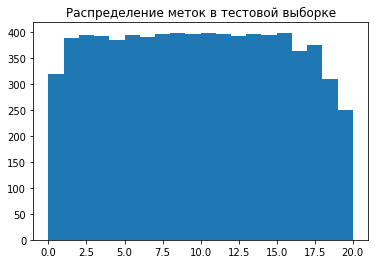

In [71]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

In [0]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [82]:
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)

scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.7, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 3.71 сек
Среднее значение функции потерь на обучении 0.9940604256034571
Среднее значение функции потерь на валидации 0.8183780669913454
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 3.48 сек
Среднее значение функции потерь на обучении 0.11703670834648912
Среднее значение функции потерь на валидации 0.7264389967766859
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 3.35 сек
Среднее значение функции потерь на обучении 0.04498738323017366
Среднее значение функции потерь на валидации 0.6937582030639811
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 3.37 сек
Среднее значение функции потерь на обучении 0.026198513463855128
Среднее значение функции потерь на валидации 0.6741801177672411
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 3.40 сек
Среднее значение функции потерь на обучении 0.017971804202402717
Среднее значение функции потерь на валидации 0.6619207240262274
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 3.35 сек
Среднее значение функ

## Оценка качества

In [83]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

354it [00:01, 181.01it/s]                              
  8%|▊         | 18/235.375 [00:00<00:01, 174.35it/s]

Среднее значение функции потерь на обучении 0.00779428705573082
Доля верных ответов 0.9993812975075128



236it [00:01, 183.90it/s]                             

Среднее значение функции потерь на валидации 0.650931179523468
Доля верных ответов 0.8189060010621348


# Альтернативная реализация на scikit-learn

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

sklearn_pipeline = Pipeline((('vect',
                              TfidfVectorizer(sublinear_tf = True,
                                              ngram_range=(1,2),
                                              max_features=180000)),
                             ('cls', LogisticRegression(C = 100,
                                                        solver = 'liblinear',
                                                        intercept_scaling =  5))))
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [111]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

Среднее значение функции потерь на обучении 2.1044279365586163
Доля верных ответов 0.999734841788934

Среднее значение функции потерь на валидации 2.3113728259487663
Доля верных ответов 0.858072225172597


In [0]:
simplenet = nn.Sequential(nn.Linear(UNIQUE_WORDS_N, 182),
                          nn.ReLU(),
                          nn.Linear(182, UNIQUE_LABELS_N))

In [103]:
scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.7, verbose=True)

best_val_loss, best_model = train_eval_loop(model=simplenet,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 27.31 сек
Среднее значение функции потерь на обучении 0.872609762485418
Среднее значение функции потерь на валидации 1.088255337486833
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 27.23 сек
Среднее значение функции потерь на обучении 0.17758081156903835
Среднее значение функции потерь на валидации 1.1857977980526828

Эпоха 2
Эпоха: 354 итераций, 35.39 сек
Среднее значение функции потерь на обучении 0.11630835589038092
Среднее значение функции потерь на валидации 1.6498410153692051

Эпоха 3
Эпоха: 354 итераций, 35.61 сек
Среднее значение функции потерь на обучении 0.09841139105502679
Среднее значение функции потерь на валидации 2.0371726381324105

Эпоха 4
Эпоха: 354 итераций, 36.05 сек
Среднее значение функции потерь на обучении 0.11062895256525004
Среднее значение функции потерь на валидации 2.7377153723421745

Эпоха 5
Эпоха: 354 итераций, 36.20 сек
Среднее значение функции потерь на обучении 0.19489635494101445
Среднее значение функции потерь на вали

In [104]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('Среднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

354it [00:04, 82.88it/s]                              
  4%|▍         | 9/235.375 [00:00<00:02, 83.72it/s]

Среднее значение функции потерь на обучении 0.16789314150810242
Доля верных ответов 0.9527134523599081



236it [00:02, 82.61it/s]                             

Среднее значение функции потерь на валидации 1.0883198976516724
Доля верных ответов 0.7136218799787573
